In [85]:
%load_ext autoreload
%autoreload 2
import tifffile as tiff
import numpy as np
import sys
from pathlib import Path
from skimage.metrics import peak_signal_noise_ratio,structural_similarity
from tqdm import tqdm
from ksvd import ApproximateKSVD
import imageio.v3 as iio
from IPython.display import HTML, Video

sys.path.append(str(Path("..").resolve()))
from src import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Denoising with dictionary-based K-SVD

ℹ️ This notebook requires the samples of OABF dataset in the `dataset/sample/motion_corrected` folder generated with [1.1.1-Visualize_OABF_Dataset](1.1.1-Visualize_OABF_Dataset.ipynb).

In [2]:
dataset = Path("../dataset/dati_per_erzelli/mini2p_astro/good_example/2024Feb06-007")
sample_dir = Path("../dataset/sample")
raw_file = dataset / "raw_data/tSer_00001.tif"
motion_corrected_file = dataset / "motion_corrected/M2P_astro_OF_001_concatenate_corrected_aligned.tiff"
motion_corrected_sample_file = sample_dir / "motion_corrected" / "oabf_good_example.tiff"
deepcad_file = dataset / "denoised/M2P_astro_OF_001_concatenate_corrected_alignedf_E_05_Iter_6048_output.tif"
deepcad_sample_file = sample_dir / "deepcad" / "oabf_good_example.tiff"

The values must be ranged 0-1 because `sigma_psd` depends on it.

In [3]:
# 6s
motion_corrected_tiff = tiff.imread(motion_corrected_sample_file).astype(np.float32)
motion_corrected = motion_corrected_tiff / np.max(motion_corrected_tiff)
deepcad_tiff = tiff.imread(deepcad_sample_file).astype(np.float32)
deepcad = deepcad_tiff / np.max(deepcad_tiff)

## K-SVD denoising

### 1. Running BM3D

In [ ]:
# 7.7s/frame (components=52)
ksvd = ApproximateKSVD(n_components=52)
k_svd = []
for i in tqdm(range(2)):
    dictionary = ksvd.fit(motion_corrected[i]).components_
    gamma = ksvd.transform(motion_corrected[i])
    k_svd.append(gamma.dot(dictionary))
k_svd = np.stack(k_svd)

In [42]:
tiff.imwrite(sample_dir / "ksvd/oabf_good_example.tiff", k_svd * np.max(motion_corrected_tiff), dtype=np.float32)

### 2. Computing evaluation metrics

In [44]:
psnr=peak_signal_noise_ratio(deepcad[0], k_svd[0], data_range=1)
ssim=structural_similarity(deepcad[0], k_svd[0], data_range=1)
cprint('PSNR','red:(DeepCAD - BM3D_AllStages)','-->',f'green:{psnr:.2f}dB')
cprint('SSIM','red:(DeepCAD - BM3D_AllStages)','-->',f'green:{ssim:.3f}')

PSNR (DeepCAD - BM3D_AllStages) --> 26.18dB
SSIM (DeepCAD - BM3D_AllStages) --> 0.507


### 3. Visually comparing results

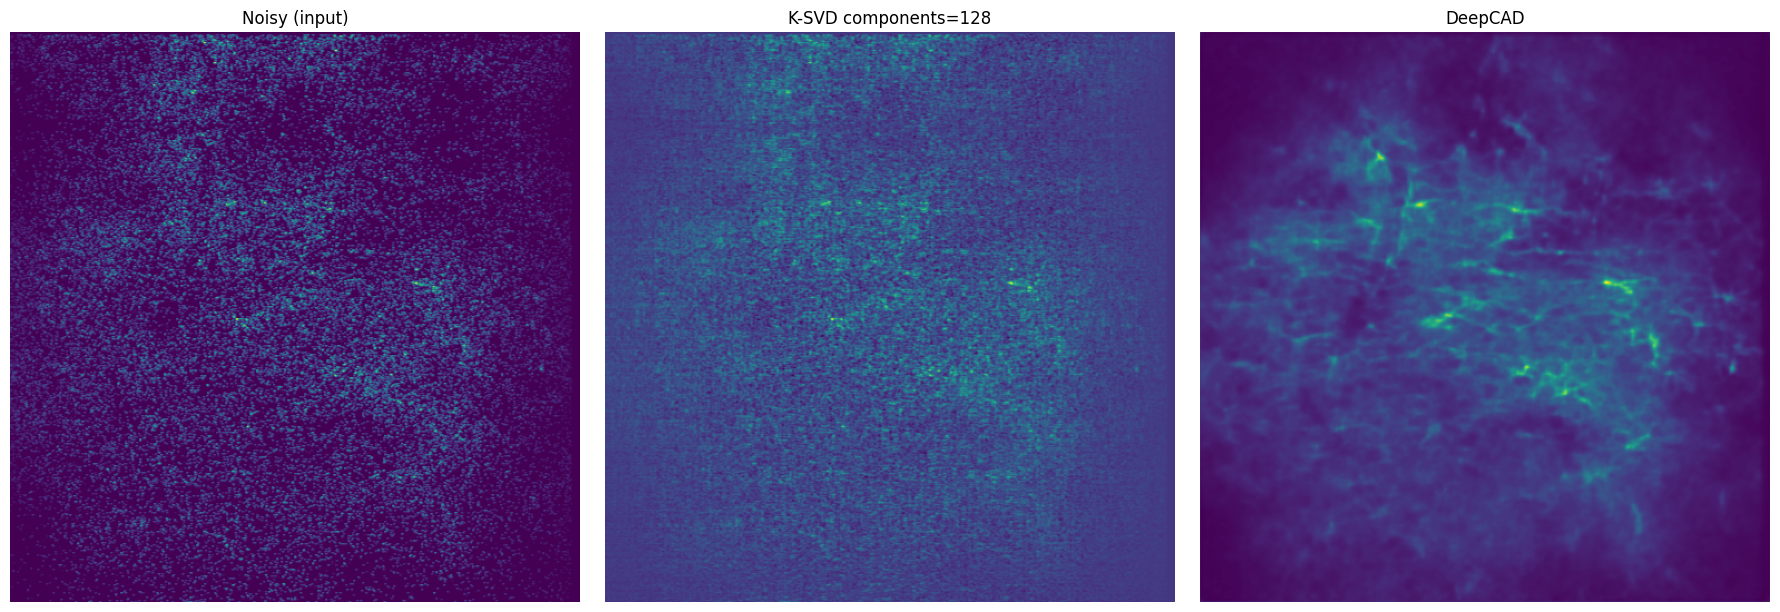

In [47]:
imshow(
    {
        "Noisy (input)": motion_corrected[0],
        "K-SVD components=128": k_svd[0],
        "DeepCAD": deepcad[0],
    },
    size=6,
)

K-SVD is meant to be used with natural images. It does not perform well with neuroscience images.
Classic methods are not tailored to Poisson statistic.